## Global Max SPEA with job bundling
- This is a variant of the SPEA algorithm in which the jobs are bundled together into 1 big circuit and sent to the backend.
- Note, the total API calls are bound by just **MAX_ITERS** as the job manager sends the circuits in a bundle and executes according to the backend limit on which we are executing

#### Trying out Job manager 
- This manager is used to **optimize** the api call time that is needed in the backend execution

In [18]:
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit import IBMQ 
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education')

ibmqfactory.load_account:WARNING:2021-06-04 12:48:02,939: Credentials are already in use. The existing account in the session will be replaced.


In [19]:
from qiskit import QuantumCircuit, execute, transpile, Aer 
from qiskit.extensions import UnitaryGate,Initialize
from qiskit.quantum_info import Statevector 
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram,plot_bloch_multivector  
import numpy as np 
from time import sleep 
import sys 
from scipy.stats import unitary_group 
import matplotlib.pyplot as plt 
%matplotlib inline 

- So what job manager does is that it takes all circuits, executes them in batches of 75 and brings back the results.
- This means, what I can do is I need (2Bm) jobs each consisting of resolution number of circuits.
- This means, I can bundle all the (2Bm.resolution) jobs together , get the result 
- Now, take first resolution number of jobs, get the max theta and cost and append to the list 
- At the end you will only have **max_iters** jobs that are sent to the backend instead of **max_iters.2*Bm** jobs, exponentially lesser api calls

In [143]:
class bundled_SPEA():
    def __init__(self,unitary,resolution = 100, error = 3, max_iters = 20):
        
        # handle resolution 
        if not isinstance(resolution,int):
            raise TypeError("Please enter the number of intervals as an integer value")  
        if resolution < 10 or resolution > 1e6:
            raise ValueError("Resolution needs to be atleast 0.1 and greater than 0.000001")
        
        self.resolution = resolution 
        
        # handle unitary
        if not isinstance(unitary, np.ndarray) and not isinstance(unitary, QuantumCircuit)\
                and not isinstance(unitary, UnitaryGate):
            raise TypeError("A numpy array or Quantum Circuit or UnitaryGate needs to be passed as the unitary matrix")

        # convert circuit to numpy array for uniformity 
        if isinstance(unitary, UnitaryGate):
            U = unitary.to_matrix()
        else: # both QC and ndarray type 
            U = unitary
        
        # note - the unitary here is not just a single qubit unitary 
        if isinstance(U,np.ndarray):
            self.dims = U.shape[0]
        else:
            self.dims = 2**(U.num_qubits)
        
        
        if isinstance(U,np.ndarray):
            self.c_unitary_gate = UnitaryGate(data = U).control(num_ctrl_qubits = 1,label = 'CU',ctrl_state = '1')
        else:
            self.c_unitary_gate = U.control(num_ctrl_qubits = 1,label = 'CU',ctrl_state = '1')

        # handle error 
        if not isinstance(error,int):
            raise TypeError("The allowable error should be provided as an int. Interpreted as 10**(-error)")
        if error <= 0:
            raise ValueError("The error threshold must be finite and greater than 0.")
            
        self.error = error 
        
        # handle max_iters 
        if not isinstance(max_iters,int):
            raise TypeError("Max iterations must be of integer type")
        if max_iters <= 0 and max_iters > 1e5:
            raise ValueError("Max iterations should be atleast 1 and less than 1e5")
        
        self.iterations = max_iters 
        self.basis = []
    
    def get_basis_vectors(self,randomize = True):
        # get the d dimensional basis for the unitary provided 
        if randomize == True:
            UR = unitary_group.rvs(self.dims)
        else:
            UR = np.identity(self.dims)

        basis = []
        for k in UR:
            basis.append(np.array(k,dtype = complex))
        return basis 
    
    def get_circuits(self,angles,state):
        '''Given an initial state and a set of angles,
          return the circuits that are generated with 
          those angles'''
        result = {'cost' : -1, 'theta' : -1}
        # all theta values are iterated over for the same state
        phi = Initialize(state)
        shots = 512
        circuits = []
        
        for theta in angles:
            qc = QuantumCircuit(1 + int(np.log2(self.dims)), 1)
            # initialize the circuit 
            qc = qc.compose(phi, qubits = list(range(1,int(np.log2(self.dims))+1)))
            # add hadamard
            qc.h(0)
            # add unitary which produces a phase kickback on control qubit
            qc = qc.compose(self.c_unitary_gate,qubits = range(1+int(np.log2(self.dims))))
            # add the inv rotation 
            qc.p(-2*np.pi*theta,0)
            # add hadamard 
            qc.h(0)
            # measure 
            qc.measure([0],[0])
            #generate all the circuits...
            circuits.append(qc)
              
        return circuits 
    
    def get_cost(self,angles,counts,shots):
        '''Generate the best cost and theta pair 
        for the particular state '''
        
        result = {'cost':-1, 'theta': -1}
        # get the cost for this theta 
        
        for k,theta in zip(counts,angles):
            # for all experiments you ran 
            try:
                C_val = (k['0'])/shots
            except:
                C_val = 0 

            if C_val > result['cost']:
                # means this is a better theta value  
                result['theta'] = theta 
                result['cost'] = C_val 
            
        return result 
    
    def get_eigen_pair(self,backend,progress = False,randomize = True,init_layout = None):
        '''Finding the eigenstate pair for the unitary'''
            
        if not isinstance(progress,bool):
            raise TypeError("Progress must be a boolean variable")
        
        if not isinstance(randomize,bool):
            raise Exception("Randomize must be a boolean variable")
        
        results = dict() 
        
        # first initialize the state phi 
        self.basis = self.get_basis_vectors(randomize)
        
        # choose a random index 
        ind = np.random.choice(self.dims) 
        phi = self.basis[ind]
        
        # doing the method 1 of our algorithm 
        # define resolution of angles and precision 
        precision = 1/10**self.error 
        samples = self.resolution 
        
        # initialization of range 
        left,right = 0,1
        shots = 512
        
        # generate the angles
        angles = np.linspace(left,right,samples)

        # First execution can be done without JobManager also...
        circs = self.get_circuits(angles,phi)
        job = execute(circs,backend = backend, shots = shots)
        counts = job.result().get_counts()
        result = self.get_cost(angles,counts,shots)
        
        # get initial estimates 
        cost = result['cost']
        theta_max = result['theta']
        best_phi = phi 

        # the range upto which theta extends iin each iteration 
        angle_range = 0.5
        # a parameter 
        a = 1 
        # start algorithm        
        iters = 0 
        found = True
        plus = (1/np.sqrt(2))*np.array([1,1])
        minus = (1/np.sqrt(2))*np.array([1,-1])
        
        #define IBMQManager instance
        manager = IBMQJobManager()
        
        while 1 - cost >= precision:
            # get angles, note if theta didn't change, then we need to 
            # again generate the same range again 
            right = min(1,theta_max + angle_range/2)
            left = max(0,theta_max - angle_range/2)
            if progress:
                print("Right :",right) 
                print("Left :",left)
            # generate the angles only if the theta has been updated 
            if found == True: 
                angles = np.linspace(left,right,samples)
            
            found = False # for this iteration 
            if progress:
                print("ITERATION NUMBER",iters+1,"...")
            
            # generate a cost dict for each of the iterations 
            # final result lists 
            thetas, costs, states = [],[],[] 
            
            # circuit list 
            circuits = []
            
            #list to store intermediate states
            phis = []
            
            # 1. Circuit generation loop
            for i in range((2*self.dims)):
                # everyone is supplied with the same range of theta in one iteration 
                #define z
                # make a list of the circuits
                if i < self.dims:
                    z = 1 
                else:
                    z = 1j 
                    
                # alter and normalise phi 
                curr_phi = best_phi + z*a*(1 - cost)*self.basis[i % self.dims]
                curr_phi = curr_phi / np.linalg.norm(curr_phi)
                phis.append(curr_phi)
                
                # bundle the circuits together ...   
                circs = self.get_circuits(angles,curr_phi)
                circuits = circuits + circs
                
                # now each iteration would see the same state as the best phi 
                # is updated once at the end of the iteration 
                    
                # also, the cost is also updated only once at the end of the iteration
            
            
            # 2. run the generated circuits 
            if progress:
                print("Transpiling circuits...")
            if init_layout is not None:
                circuits = transpile(circuits=circuits,backend=backend,initial_layout = init_layout,optimization_level = 3)
            else:
                circuits = transpile(circuits=circuits,backend=backend,optimization_level = 3)
                
            job_set = manager.run(circuits,backend = backend,name = 'Job_set'+str(iters),shots=shots)
            if progress:
                print("Transpilation Done!\nJob sent...")
            job_result = job_set.results()        
            
            # now get the circuits in chunks of resolution each 
            if progress:
                print("Job has returned")
                
                
            # 3. Result generation loop
            for i in range((2*self.dims)):
                # get the results of this basis state
                # it will have resolution number of circuits...
                counts = []
                for j in range(i*self.resolution, (i+1)*self.resolution):
                    # in this you'll get the counts 
                    counts.append(job_result.get_counts(j))
                
                result = self.get_cost(counts,angles,shots)
                
                # get the estimates for this basis 
                curr_theta = result['theta']
                curr_cost = result['cost']
                curr_phi = phis[i] # the result was generated pertaining to this phi 
                    
                if curr_cost > cost: # then only add this cost in the cost and states list 
                    thetas.append(float(curr_theta))
                    costs.append(float(curr_cost))
                    states.append(curr_phi)
                    found = True
                
                if progress:
                    sys.stdout.write('\r')
                    sys.stdout.write("%f %%completed" % (100*(i+1)/(2*self.dims)))
                    sys.stdout.flush()
                
                
            if found == False:
                # phi was not updated , change a 
                a = a/2
                if progress:
                    print("\nNo change, updating a...")
            else:
                # if found is actually true, then only update 
                
                # O(n) , would update this though 
                index = np.argmax(costs)
                # update the parameters of the model 
                cost = costs[index]
                theta_max = thetas[index]
                best_phi = states[index]
                if progress:
                    print("Best Phi is :",best_phi)
                    print("Theta estimate :",theta_max)
                    print("Current cost :",cost) 
                angle_range /= 2 # updated phi and thus theta too -> refine theta range
            
            # update the iterations 
            iters+=1 
            if progress:
                print("\nCOST :",cost)
                print("THETA :",theta_max)
            
            if iters >= self.iterations:
                print("Maximum iterations reached for the estimation.\nTerminating algorithm...")
                break 
      # add cost, eigenvector and theta to the dict 
        results['cost'] = cost 
        results['theta'] = theta_max 
        results['state'] = best_phi 
        
        return results
            

### Testing
- This algorithm is tested for a phase gate of $ \theta = \frac{1}{9} $ 

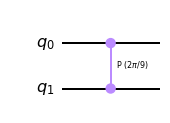

In [152]:
q = QuantumCircuit(2)
q.cp(2*np.pi*(1/9),0,1)
q.draw('mpl')

In [153]:
spe = bundled_SPEA(q,resolution=30,error = 3,max_iters=10)

- Choosing backend as **ibmq_santiago**

In [156]:
santiago = provider.get_backend('ibmq_santiago')

In [ ]:
thetas = []
for k in range(5):
    result = spe.get_eigen_pair(backend=santiago,progress=True)
    print("Result is :",result)
    thetas.append(result['theta'])

In [27]:
thetas

[1.0, 0.0, 0.06896551724137931, 0.0, 0.034482758620689655]

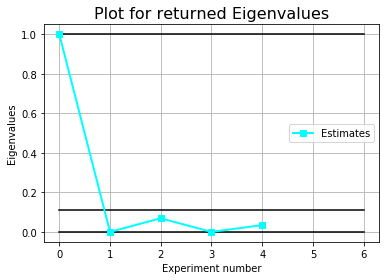

In [29]:
plt.title("Plot for returned Eigenvalues",fontsize = 16)
plt.xlabel("Experiment number")
plt.ylabel("Eigenvalues")
plt.plot([0,6],[0,0],color = 'black')
plt.plot([0,6],[1,1],color = 'black')
plt.plot([0,6],[0.111,0.111],color = 'black')
plt.plot(list(range(5)), thetas, label = 'Estimates', color = 'cyan', linewidth = 2, marker = 's')
plt.legend()
plt.grid()

## Does transpilation speed up ?
- Let us see whether transpilation speeds up when initial layout is provided

In [163]:
# try to find our intial layouts for the 1 and 2 qubit unitaries
# let us look at yorktown to get the the 3 vertex clique for the 2 qubit unitaries
# note - > [2,3,4] are all connected to each other and thus transpilation would be pretty 
# nicely done in the case where we have 2 qubit unitaries
from qiskit.circuit.random import random_circuit

yorktown= provider.get_backend('ibmq_5_yorktown')
york_initial_layout = [2,3,4]

In [169]:
q1 = random_circuit(3,depth = 7,measure = True)

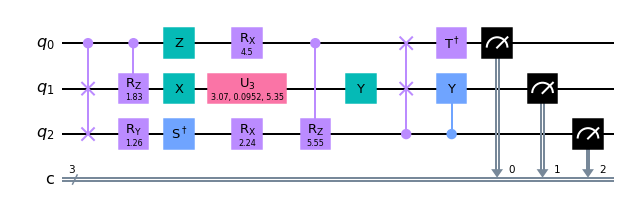

In [170]:
q1.draw('mpl')

In [171]:
basis = yorktown.configuration().basis_gates
basis 

['id', 'rz', 'sx', 'x', 'cx', 'reset']

- Without initial layout

In [172]:
circ = transpile(q1,backend=yorktown,basis_gates=basis,optimization_level=3)
print("Non-local gates :",circ.num_nonlocal_gates())

Non-local gates : 19


- With initial layout

In [173]:
circ = transpile(q1,backend=yorktown,basis_gates=basis,initial_layout=york_initial_layout,optimization_level=3)
print("Non-local gates :",circ.num_nonlocal_gates())

Non-local gates : 19
